## Text Emotion Classification

### Dataset links:

- emotions-dataset-for-nlp: <a>https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp</a>
- glove-global-vectors-for-word-representation: <a>https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation</a>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing as mp
import pandas as pd
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Read data

In [3]:
# Read datasets
df_train = pd.read_csv("./emotions-dataset-for-nlp/train.txt", sep=";", names=["Text", "Emotion"])
df_train

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df_valid = pd.read_csv("./emotions-dataset-for-nlp/val.txt", sep=";", names=["Text", "Emotion"])
df_valid

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [5]:
df_test = pd.read_csv("./emotions-dataset-for-nlp/test.txt", sep=";", names=["Text", "Emotion"])
df_test

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


## Explore Train Dataset

<Axes: xlabel='Emotion', ylabel='count'>

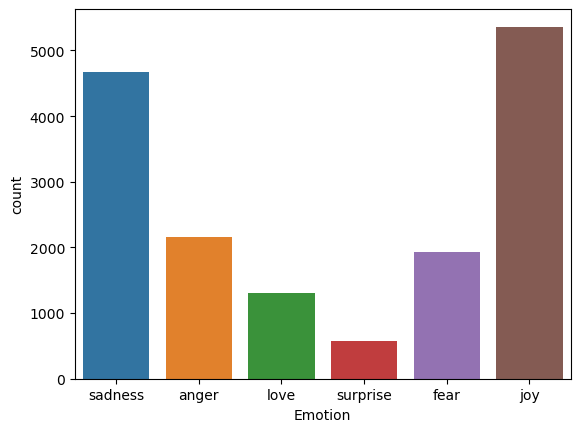

In [6]:
sns.countplot(x="Emotion", data=df_train)

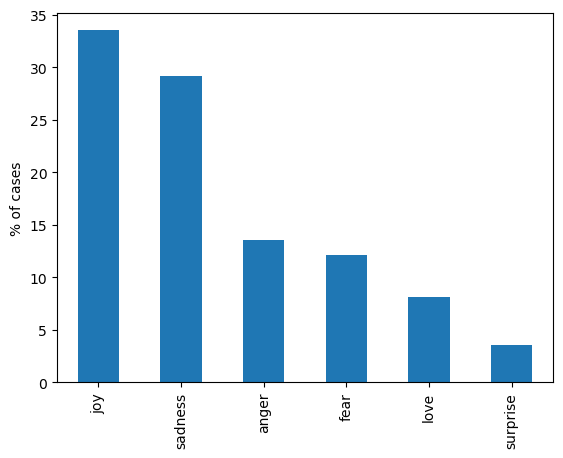

In [7]:
s = df_train["Emotion"].value_counts()/df_train.shape[0]*100
s.plot(kind='bar')
plt.ylabel("% of cases")
plt.show()

### Check for null values

In [8]:
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

### Check duplicate values

In [9]:
df_train.duplicated().sum() # 1 duplicate value present

1

### Check for duplicate text with different emotions

In [10]:
df_train["Text"].duplicated().sum() # Total 31 cases found

31

### Drop the text duplicates and keep the first one.

In [11]:
df_train.drop_duplicates(subset=["Text"], keep='first', inplace=True)

In [12]:
df_train

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Preprocess data

In [13]:
nlp = spacy.load("en_core_web_lg")

In [14]:
def getStopWordCount(text):
    doc = nlp(text)
    stop_words = [token.text for token in doc if token.is_stop]
    return len(stop_words)

In [15]:
df_train["StopCount"] = df_train["Text"].apply(getStopWordCount)

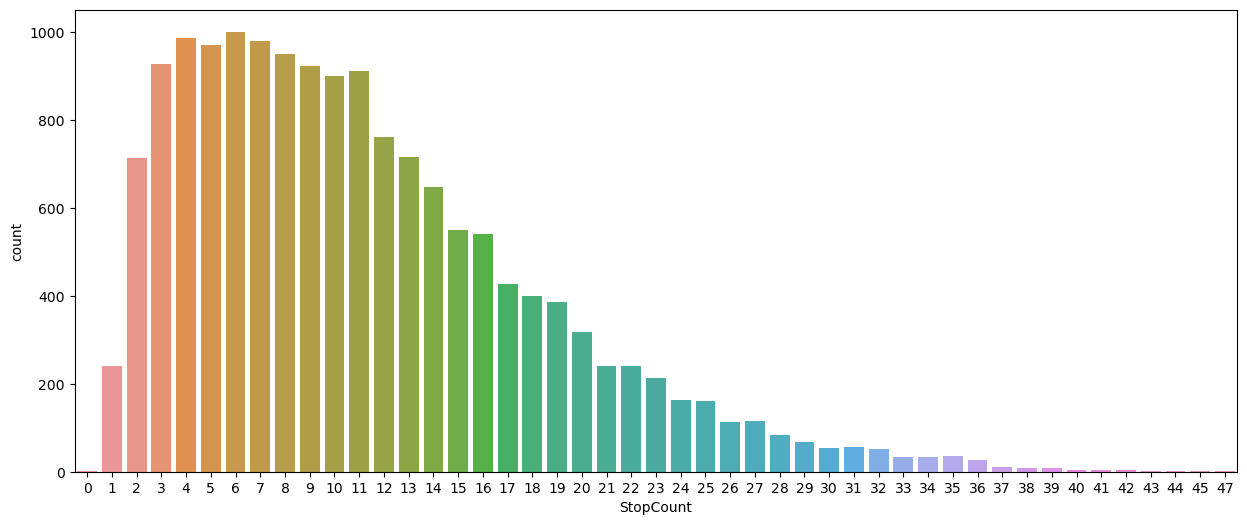

In [16]:
plt.figure(figsize=(15,6))
sns.countplot(x="StopCount", data=df_train)
plt.show()

The text contains a lot of stop words. Those need to be processed before training

## Explore Test Data

<Axes: xlabel='Emotion', ylabel='count'>

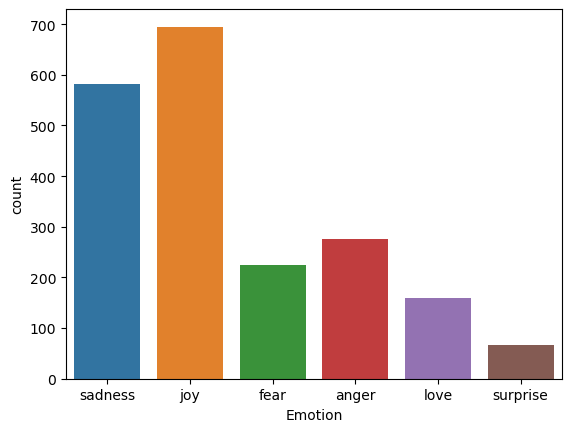

In [17]:
sns.countplot(x="Emotion", data=df_test)

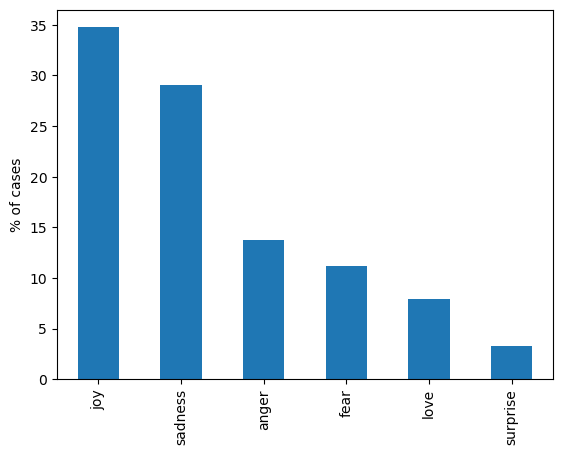

In [18]:
s = df_test["Emotion"].value_counts()/df_test.shape[0]*100
s.plot(kind='bar')
plt.ylabel("% of cases")
plt.show()

In [19]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [20]:
df_test["Text"].duplicated().sum() # No Duplicate text

0

In [21]:
df_test["StopCount"] = df_test["Text"].apply(getStopWordCount)

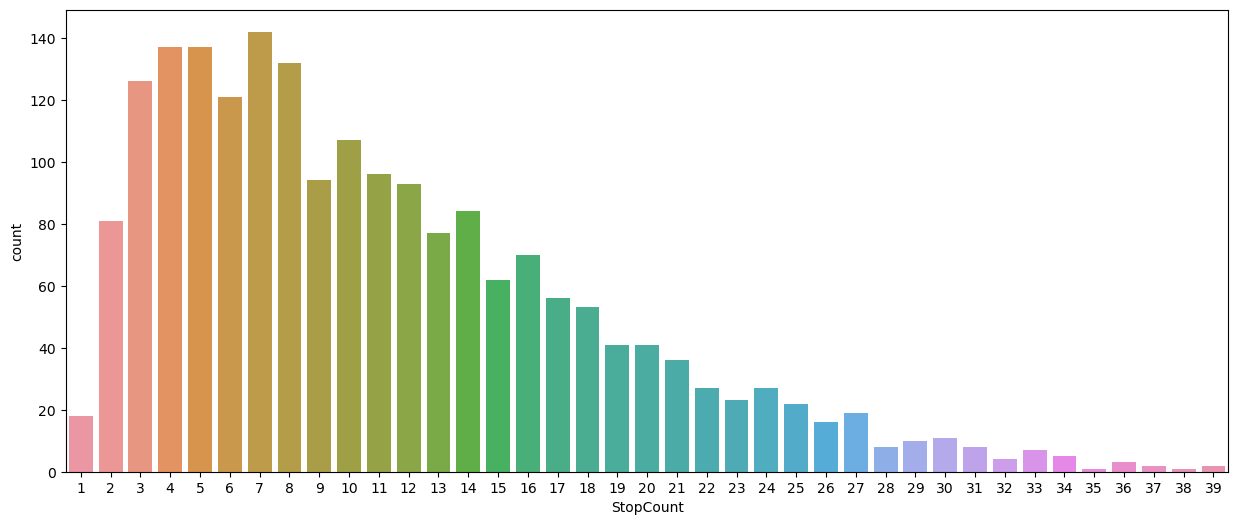

In [22]:
plt.figure(figsize=(15,6))
sns.countplot(x="StopCount", data=df_test)
plt.show()

## Explore Validation Data

<Axes: xlabel='Emotion', ylabel='count'>

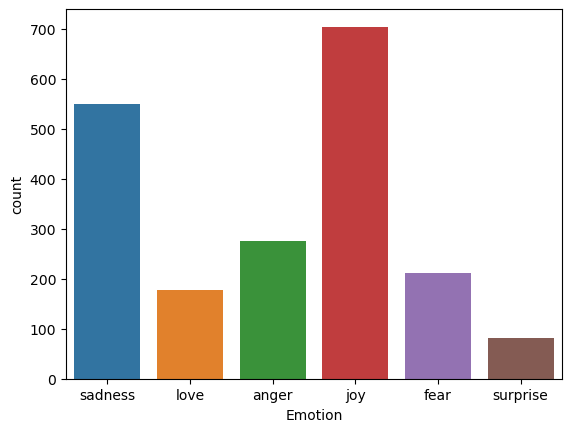

In [23]:
sns.countplot(x="Emotion", data=df_valid)

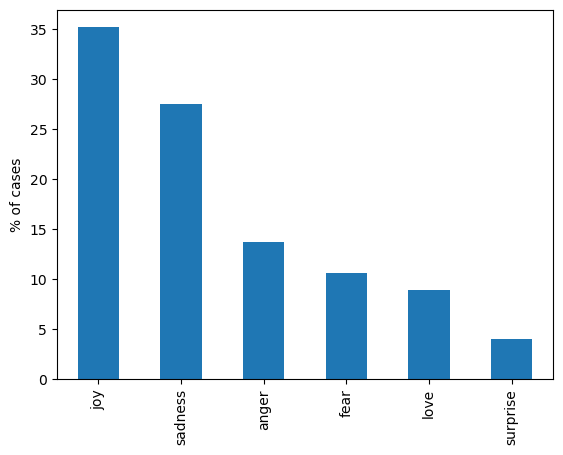

In [24]:
s = df_valid["Emotion"].value_counts()/df_valid.shape[0]*100
s.plot(kind='bar')
plt.ylabel("% of cases")
plt.show()

In [25]:
df_valid.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [26]:
df_valid["Text"].duplicated().sum() # 2 Duplicate text

2

In [27]:
df_valid.drop_duplicates(subset=["Text"], keep='first', inplace=True)

In [28]:
df_valid

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [29]:
df_valid["StopCount"] = df_valid["Text"].apply(getStopWordCount)

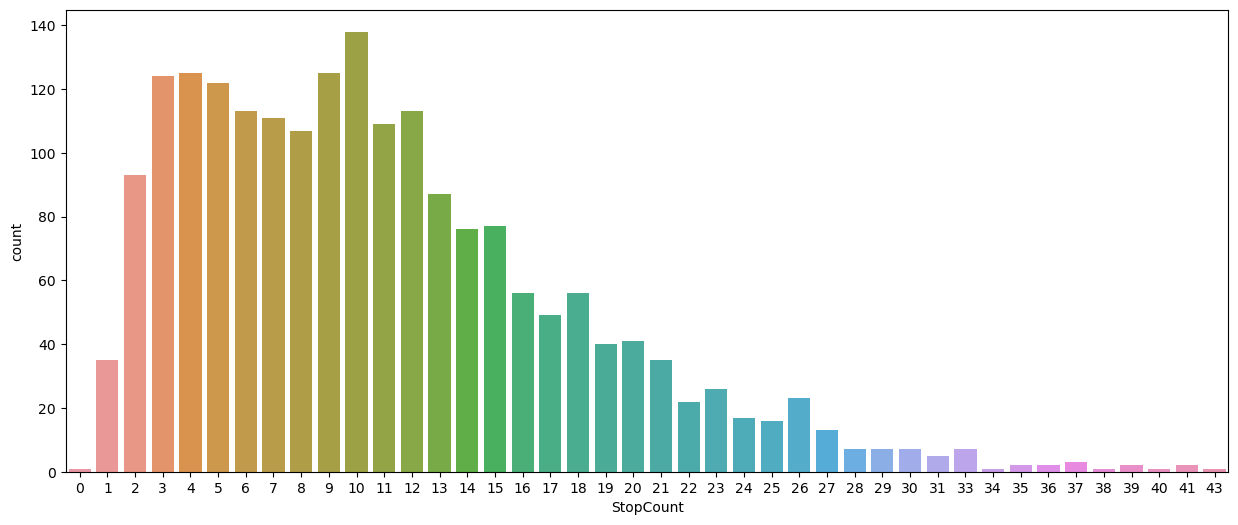

In [30]:
plt.figure(figsize=(15,6))
sns.countplot(x="StopCount", data=df_valid)
plt.show()

## Check Data Leakage/Same Text In Two DataFrames

In [31]:
df_train.merge(df_test, how='inner', on=["Text", "Emotion"])

,Text,Emotion,StopCount_x,StopCount_y


In [32]:
df_train.merge(df_valid, how='inner', on=["Text", "Emotion"])

,Text,Emotion,StopCount_x,StopCount_y


No duplicate data in training and testing or validation data found.

## Data cleaning
This process containing removing of stop words/ punctuations/ links/ emails/ numbers, lowering the words, lemmetizing the words

In [33]:
stop_words = stopwords.words("english")

In [34]:
# def remove_stops(text):
#     tokens = word_tokenize(text)
#     filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
#     return " ".join(filtered_tokens)
def lower_text_remove_number(text):
    return "".join([i for i in text.lower() if not i.isdigit()])
def remove_punctuations(text):
    text = re.sub(r'[^\w\s]', '', text)
    return re.sub(r' +',' ',text)
def remove_urls(text):
    urls = re.findall("https?://\S+|www\.\S+", text)
    for url in urls:
        text = text.replace(url,"")
    return text
def remove_stop_and_lemmetize_word(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    return " ".join(lemmas)

In [35]:
def preprocess_text(text):
    text = remove_urls(text)
    text = lower_text_remove_number(text)
    text = remove_punctuations(text)
    text = remove_stop_and_lemmetize_word(text)
    return text

In [36]:
def process_df(df):
    df["Text_Processed"] = df["Text"].apply(preprocess_text)
    return df

### Preprocessing with Multiprocessing to speedup the spacy lemmatization.

In [37]:
def lemm_Df_with_multiprocessing(df):
    df_list = np.array_split(df, 8)
    with mp.Pool(8) as p:
        result = p.map(process_df, df_list)
    return pd.concat(result, axis=0)

In [38]:
df_train = lemm_Df_with_multiprocessing(df_train)

In [39]:
df_test = lemm_Df_with_multiprocessing(df_test)

In [40]:
df_valid = lemm_Df_with_multiprocessing(df_valid)

### Processed Texts

In [41]:
df_train

,Text,Emotion,StopCount,Text_Processed
0,i didnt feel humiliated,sadness,2,not feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,15,go feel hopeless damned hopeful around someone...
2,im grabbing a minute to post i feel greedy wrong,anger,4,grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,13,ever feel nostalgic fireplace know still property
4,i am feeling grouchy,anger,2,feel grouchy
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,16,brief time beanbag say anna feel like beat
15996,i am now turning and i feel pathetic that i am...,sadness,12,turn feel pathetic still wait table sub teachi...
15997,i feel strong and good overall,joy,2,feel strong good overall
15998,i feel like this was such a rude comment and i...,anger,8,feel like rude comment glad


In [42]:
df_test

,Text,Emotion,StopCount,Text_Processed
0,im feeling rather rotten so im not very ambiti...,sadness,7,feel rather rotten ambitious right
1,im updating my blog because i feel shitty,sadness,4,update blog feel shitty
2,i never make her separate from me because i do...,sadness,14,never make separate ever want feel like ashamed
3,i left with my bouquet of red and yellow tulip...,joy,11,leave bouquet red yellow tulip arm feel slight...
4,i was feeling a little vain when i did this one,sadness,8,feel little vain one
...,...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,29,keep feel like someone unkind wrong think get ...
1996,im feeling a little cranky negative after this...,anger,4,feel little cranky negative doctor appointment
1997,i feel that i am useful to my people and that ...,joy,11,feel useful people give great feeling achievement
1998,im feeling more comfortable with derby i feel ...,joy,11,feel comfortable derby feel though start step ...


In [43]:
df_valid

,Text,Emotion,StopCount,Text_Processed
0,im feeling quite sad and sorry for myself but ...,sadness,9,feel quite sad sorry ill snap soon
1,i feel like i am still looking at a blank canv...,sadness,7,feel like still look blank canvas blank piece ...
2,i feel like a faithful servant,love,2,feel like faithful servant
3,i am just feeling cranky and blue,anger,4,feel cranky blue
4,i can have for a treat or if i am feeling festive,joy,9,treat feel festive
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,19,ssa examination tomorrow morning quite well pr...
1996,i constantly worry about their fight against n...,joy,16,constantly worry fight nature push limit inner...
1997,i feel its important to share this info for th...,joy,9,feel important share info experience thing
1998,i truly feel that if you are passionate enough...,joy,13,truly feel passionate enough something stay tr...


## Prepare data for training

#### All the emotions will be one hot encoded and the processed texts will be converted to TF-IDF vectors.

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
df_train = pd.concat([df_train, pd.get_dummies(df_train["Emotion"])], axis=1)

In [46]:
df_train

,Text,Emotion,StopCount,Text_Processed,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,sadness,2,not feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,sadness,15,go feel hopeless damned hopeful around someone...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,anger,4,grab minute post feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,love,13,ever feel nostalgic fireplace know still property,0,0,0,1,0,0
4,i am feeling grouchy,anger,2,feel grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,16,brief time beanbag say anna feel like beat,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,sadness,12,turn feel pathetic still wait table sub teachi...,0,0,0,0,1,0
15997,i feel strong and good overall,joy,2,feel strong good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,anger,8,feel like rude comment glad,1,0,0,0,0,0


In [47]:
def decode_prediction(output):
    outputs = ["anger","fear","joy","love","sadness","surprise"]
    maxs = np.argmax(output, axis=-1)
    maxs = [[outputs[i]] for i in maxs]
    return np.array(maxs)

In [48]:
X_train = df_train["Text_Processed"]
y_train = df_train[["anger","fear","joy","love","sadness","surprise"]].values
X_test = df_test["Text_Processed"]
y_test = df_test["Emotion"]
X_valid = df_valid["Text_Processed"]
y_valid = df_valid["Emotion"]

In [49]:
vectorizer = TfidfVectorizer(min_df = 5, max_df=1.0)

In [50]:
X_train = vectorizer.fit_transform(X_train).toarray()

In [51]:
X_test = vectorizer.transform(X_test).toarray()
X_valid = vectorizer.transform(X_valid).toarray()

In [52]:
X_train.shape, X_test.shape, X_valid.shape

((15969, 2838), (2000, 2838), (1998, 2838))

In [53]:
tfidf_df = pd.DataFrame(X_train, columns = vectorizer.get_feature_names_out())

In [54]:
tfidf_df

,abandon,ability,able,absolute,absolutely,abuse,abused,academic,accept,acceptable,...,yes,yesterday,yet,yoga,york,young,youth,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Decision-Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
clf = DecisionTreeClassifier()

In [57]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [58]:
y_pred = decode_prediction(clf.predict(X_test))

In [59]:
from sklearn.metrics import classification_report, accuracy_score

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.81      0.83      0.82       275
        fear       0.78      0.79      0.79       224
         joy       0.85      0.86      0.86       695
        love       0.72      0.72      0.72       159
     sadness       0.86      0.84      0.85       581
    surprise       0.53      0.53      0.53        66

    accuracy                           0.82      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.82      0.82      0.82      2000



In [61]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.82


In [62]:
df_test["Predicted_DecisionTree"] = y_pred
df_test

,Text,Emotion,StopCount,Text_Processed,Predicted_DecisionTree
0,im feeling rather rotten so im not very ambiti...,sadness,7,feel rather rotten ambitious right,sadness
1,im updating my blog because i feel shitty,sadness,4,update blog feel shitty,sadness
2,i never make her separate from me because i do...,sadness,14,never make separate ever want feel like ashamed,sadness
3,i left with my bouquet of red and yellow tulip...,joy,11,leave bouquet red yellow tulip arm feel slight...,joy
4,i was feeling a little vain when i did this one,sadness,8,feel little vain one,sadness
...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,29,keep feel like someone unkind wrong think get ...,sadness
1996,im feeling a little cranky negative after this...,anger,4,feel little cranky negative doctor appointment,anger
1997,i feel that i am useful to my people and that ...,joy,11,feel useful people give great feeling achievement,joy
1998,im feeling more comfortable with derby i feel ...,joy,11,feel comfortable derby feel though start step ...,joy


## Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
clf = RandomForestClassifier()

In [65]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [66]:
y_pred = decode_prediction(clf.predict(X_test))

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.67      0.92      0.78       275
        fear       0.84      0.83      0.84       224
         joy       0.88      0.89      0.89       695
        love       0.81      0.63      0.71       159
     sadness       0.92      0.84      0.88       581
    surprise       0.72      0.50      0.59        66

    accuracy                           0.84      2000
   macro avg       0.81      0.77      0.78      2000
weighted avg       0.85      0.84      0.84      2000



In [68]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.841


In [69]:
df_test["Predicted_RandomForest"] = y_pred
df_test

,Text,Emotion,StopCount,Text_Processed,Predicted_DecisionTree,Predicted_RandomForest
0,im feeling rather rotten so im not very ambiti...,sadness,7,feel rather rotten ambitious right,sadness,sadness
1,im updating my blog because i feel shitty,sadness,4,update blog feel shitty,sadness,sadness
2,i never make her separate from me because i do...,sadness,14,never make separate ever want feel like ashamed,sadness,sadness
3,i left with my bouquet of red and yellow tulip...,joy,11,leave bouquet red yellow tulip arm feel slight...,joy,joy
4,i was feeling a little vain when i did this one,sadness,8,feel little vain one,sadness,sadness
...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,29,keep feel like someone unkind wrong think get ...,sadness,anger
1996,im feeling a little cranky negative after this...,anger,4,feel little cranky negative doctor appointment,anger,anger
1997,i feel that i am useful to my people and that ...,joy,11,feel useful people give great feeling achievement,joy,joy
1998,im feeling more comfortable with derby i feel ...,joy,11,feel comfortable derby feel though start step ...,joy,joy


## Word Embedding and Sequential Model with Dense Layers

In [70]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [71]:
X_train = df_train["Text_Processed"]
y_train = df_train["Emotion"]
X_test = df_test["Text_Processed"]
y_test = df_test["Emotion"]
X_valid = df_valid["Text_Processed"]
y_valid = df_valid["Emotion"]

#### Encode outputs using label encoder and to_categorical. This can also be done using pd.get_dummies

In [72]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

In [73]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

In [74]:
y_train.shape

(15969, 6)

In [75]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [76]:
# Index of any word in the tokenizer object
tokenizer.word_index['towards']

228

In [77]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_valid = tokenizer.texts_to_sequences(X_valid)

In [78]:
max_len = max([len(seq) for seq in sequences_train+sequences_test+sequences_valid])
max_len

35

In [79]:
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_valid = pad_sequences(sequences_valid, maxlen=max_len, truncating='pre')

In [80]:
vocabSize = len(tokenizer.index_word) + 1
# The reason for this +1 is to include all the words inthe vocabulary into embedding layer. 
# As the tokenizer is having 1 indexed.
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 12700


### Create dictionary of all the words present in global-vectors
### Create one array of vectors having vectors in the index as per the tokenizer index.

* model = tf.keras.Sequential()
* model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
* The model will take as input an integer matrix of size (batch,
input_length), and the largest integer (i.e. word index) in the input
should be no larger than 999 (vocabulary size).
Now model.output_shape is (None, 10, 64), where `None` is the batch
dimension.

In [81]:
embeddings = {}
with open("./glove-global-vectors-for-word-representation/glove.6B.200d.txt", "r") as f:
    lines = f.readlines()
for line in lines:
    word, emb = line.split(" ", maxsplit=1)
    embeddings[word] = np.fromstring(emb, sep=" ", dtype=np.float32)

In [82]:
embedding_dim = len(embeddings.get(","))
embedding_dim

200

In [83]:
# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((vocabSize, embedding_dim))
hits=0
miss=0
miss_word = []
for word, idx in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[idx] = embedding_vector
        hits += 1
    else:
        miss += 1
        miss_word.append(word)
print("Converted %d words (%d misses)" % (hits, miss))

Converted 11597 words (1102 misses)


### Build the model with Embedding and Dense layer with Adam optimizer and softmax output at the end

In [84]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Flatten, Input
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [85]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    model = Sequential()
    model.add(Embedding(input_dim = vocabSize,output_dim = 200, input_length = X_train.shape[1], weights=[embedding_matrix], trainable=False))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 200)           2540000   
                                                                 
 flatten (Flatten)           (None, 7000)              0         
                                                                 
 dense (Dense)               (None, 512)               3584512   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 6,390,246
Trainable params: 3,850,246
Non-trainable params: 2,540,000
_________________________________________________________________


In [87]:
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="accuracy")
        plt.plot(self.x, self.val_losses, label="val_accuracy")
        plt.legend()
        plt.show();

In [88]:
callbacks = [PlotLosses()]

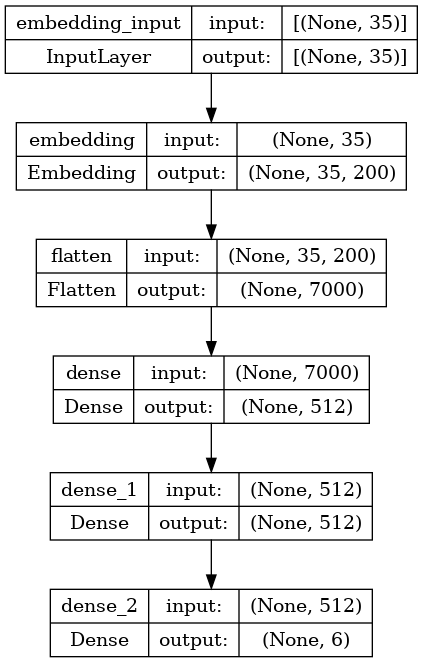

In [89]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

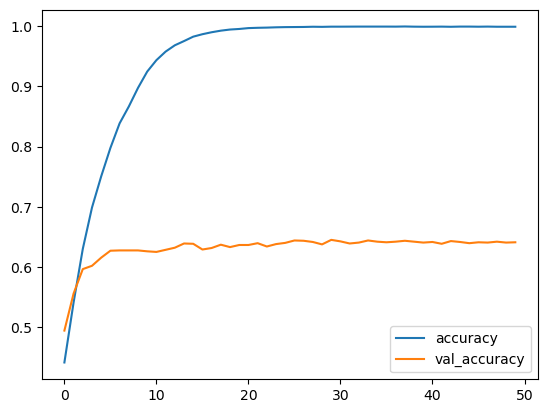

63/63 [==============================] - 1s 20ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 2.1527 - val_accuracy: 0.6411


In [90]:
model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    batch_size=256,
                    epochs=50,
                    callbacks=callbacks)

### Build model with LSTM, Didirectional, Dense layer and Adam optimizer

In [103]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope():
    model1 = Sequential()
    model1.add(Embedding(input_dim = vocabSize, output_dim = 200, input_length = X_train.shape[1], weights = [embedding_matrix], trainable=False))
    model1.add(Bidirectional(LSTM(256, activation='relu',dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
    model1.add(Bidirectional(LSTM(128, activation='relu',dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
    model1.add(Bidirectional(LSTM(128, activation='relu',dropout = 0.2, recurrent_dropout = 0.2,)))
    model1.add(Dense(6, activation='softmax'))
    adam = Adam(learning_rate=0.0001)
    model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [104]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 200)           2540000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 35, 512)          935936    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 35, 256)          656384    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                      

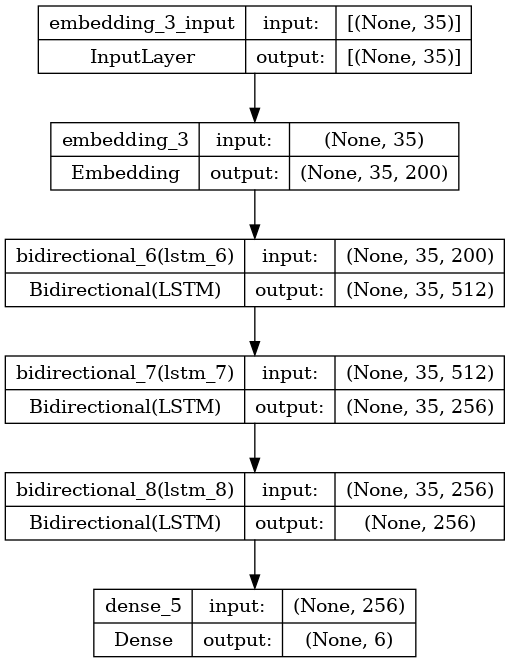

In [105]:
plot_model(model1, show_shapes=True)

In [106]:
checkpoint = ModelCheckpoint("./results/LSTMModel.h5", save_weights_only=False, monitor="val_accuracy", model='max')

In [107]:
callbacks = [PlotLosses(), checkpoint]

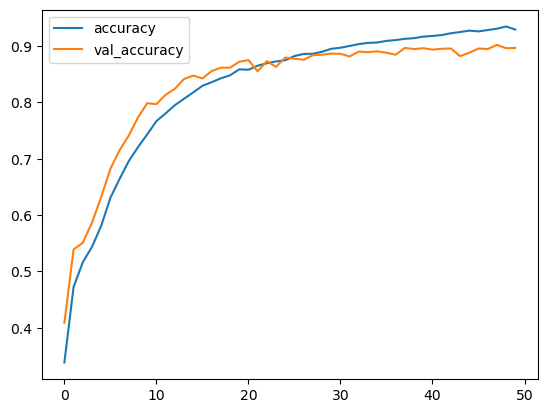

63/63 [==============================] - 142s 2s/step - loss: 0.1756 - accuracy: 0.9290 - val_loss: 0.2997 - val_accuracy: 0.8964


In [108]:
history = model1.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    batch_size=256,
                    epochs=50,
                    callbacks=callbacks
                   )

In [113]:
model1 = tf.keras.models.load_model("./results/LSTMModel.h5")

In [114]:
y_pred = model1.predict(X_test)

63/63 [==============================] - 6s 81ms/step


In [115]:
le.inverse_transform(np.argmax(y_pred,axis=-1))

array(['sadness', 'sadness', 'sadness', ..., 'joy', 'joy', 'surprise'],
      dtype=object)

In [116]:
df_test["LSTM_Prediction"] = le.inverse_transform(np.argmax(y_pred,axis=-1))
df_test

,Text,Emotion,StopCount,Text_Processed,Predicted_DecisionTree,Predicted_RandomForest,LSTM_Prediction
0,im feeling rather rotten so im not very ambiti...,sadness,7,feel rather rotten ambitious right,sadness,sadness,sadness
1,im updating my blog because i feel shitty,sadness,4,update blog feel shitty,sadness,sadness,sadness
2,i never make her separate from me because i do...,sadness,14,never make separate ever want feel like ashamed,sadness,sadness,sadness
3,i left with my bouquet of red and yellow tulip...,joy,11,leave bouquet red yellow tulip arm feel slight...,joy,joy,joy
4,i was feeling a little vain when i did this one,sadness,8,feel little vain one,sadness,sadness,sadness
...,...,...,...,...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,29,keep feel like someone unkind wrong think get ...,sadness,anger,anger
1996,im feeling a little cranky negative after this...,anger,4,feel little cranky negative doctor appointment,anger,anger,anger
1997,i feel that i am useful to my people and that ...,joy,11,feel useful people give great feeling achievement,joy,joy,joy
1998,im feeling more comfortable with derby i feel ...,joy,11,feel comfortable derby feel though start step ...,joy,joy,joy


In [123]:
y_test = le.inverse_transform(np.argmax(y_test,axis=-1))

In [125]:
y_pred = le.inverse_transform(np.argmax(y_pred,axis=-1))

In [126]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8805


In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.91      0.84      0.87       275
        fear       0.89      0.80      0.84       224
         joy       0.90      0.91      0.90       695
        love       0.75      0.77      0.76       159
     sadness       0.91      0.94      0.93       581
    surprise       0.64      0.82      0.72        66

    accuracy                           0.88      2000
   macro avg       0.83      0.84      0.84      2000
weighted avg       0.88      0.88      0.88      2000



In [117]:
import pickle

In [118]:
with open("./results/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [119]:
with open("./results/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [120]:
df_test.to_csv("./results/predictions.csv", index=False)